# Walks, Paths, and Connectivity (Companion Notebook)

This notebook is a companion to the slide sets: 4A_Walks on Graphs and 4B_Paths and Connectivity.

By the end of this notebook you should be able to:

1. **Define walks and count them** using powers of the adjacency matrix  
   \[
   \Omega^{(\ell)}_{i,j} = [A^\ell]_{i,j}.
   \]
2. **Use closed-walk counts** to compute the number of triangles  
   \[
   T = \frac{\mathrm{Tr}(A^3)}{6}.
   \]
3. **Compute shortest paths and distances** (undirected and directed graphs).
4. **Compute connected components (CCs)** in undirected graphs and **strongly connected components (SCCs)** in directed graphs.
5. **Compute the condensation DAG** of a directed graph.

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (6, 4)

## Helper functions (printing and plots)

To keep the notebook readable, we define a few helper functions that we will reuse throughout.
You do **not** need to modify these functions—just understand what they do.

> `adjacency_matrix_numpy(G, nodelist=None, weight=None)`

Converts a NetworkX graph `G` into its **adjacency matrix** \(A\) as a NumPy array.

- Fixes a node ordering (important when interpreting matrix entries).
- Returns both the matrix `A` and the node ordering used.
- If `weight=None`, the matrix is unweighted (0/1 entries).

This lets us compute quantities from the slides such as
\( \bm d = A\mathbf{1}_n \), walk counts \( A^\ell \), and triangle counts.

---

> `draw_graph(G, title="", pos=None, directed=False)`

Draws the graph for visualization.

- Uses a spring layout by default.
- Shows arrows if `directed=True`.
- The layout is **only for visualization** and does not affect computations.

---

> `spy_matrix(A, title="")`

Displays a **spy plot** of a matrix \(A\).

- Visualizes where matrix entries are nonzero.
- Useful for seeing sparsity and symmetry in adjacency matrices.

These helpers let us move easily between **graphs**, **matrices**, and **visual intuition**.


In [2]:
def adjacency_matrix_numpy(G, nodelist=None, weight=None):
    """Return the adjacency matrix as a NumPy array with a fixed node ordering."""
    if nodelist is None:
        try:
            nodelist = sorted(G.nodes())
        except TypeError:
            nodelist = list(G.nodes())
    A = nx.to_numpy_array(G, nodelist=nodelist, weight=weight, dtype=float)
    return A, nodelist

def draw_graph(G, title="", pos=None, directed=False):
    plt.figure()
    if pos is None:
        pos = nx.spring_layout(G, seed=0)
    nx.draw_networkx(G, pos=pos, with_labels=True, node_size=600, arrows=directed)
    plt.title(title)
    plt.axis("off")
    plt.show()

def spy_matrix(A, title=""):
    plt.figure()
    plt.spy(A)
    plt.title(title)
    plt.show()

# Part I — Walks and adjacency powers (Slide set 4.A)

## Walks (recap)

A **walk** of length $\ell$ from node $i$ to node $j$ is a sequence of $\ell+1$ nodes
$
(i,r_1,r_2,\ldots,r_{\ell-1},j)
$
such that consecutive nodes are adjacent. Walks **may repeat nodes and edges**.

The key theorem from the slides is:
$$
\Omega^{(\ell)}_{i,j} = [A^\ell]_{i,j},
$$
where $\Omega^{(\ell)}_{i,j}$ is the number of walks of length $\ell$ from $i$ to $j$.


## Example 1: A 4-node chain graph

We build a simple chain graph with 4 nodes:
$$
1-2-3-4.
$$
We compute $A$, $A^2$, and $A^3$ and interpret selected entries as walk counts.


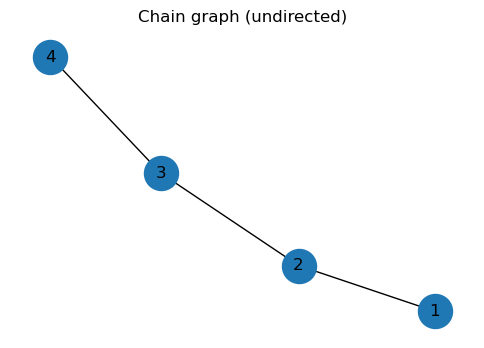

Node ordering: [1, 2, 3, 4]
Adjacency matrix A:
 [[0 1 0 0]
 [1 0 1 0]
 [0 1 0 1]
 [0 0 1 0]]


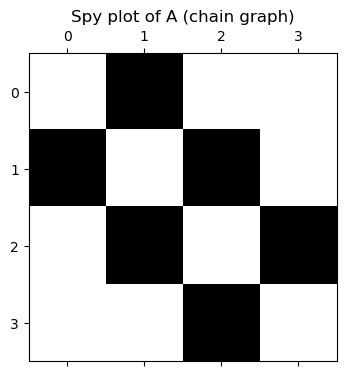

In [3]:
# Build the chain graph: 1-2-3-4
G_chain = nx.Graph()
G_chain.add_edges_from([(1, 2), (2, 3), (3, 4)])

draw_graph(G_chain, title="Chain graph (undirected)")

A, nodes = adjacency_matrix_numpy(G_chain)
print("Node ordering:", nodes)
print("Adjacency matrix A:\n", A.astype(int))
spy_matrix(A, title="Spy plot of A (chain graph)")

In [8]:
# Count walks via powers of A
A2 = A @ A
A3 = A2 @ A

print("A^2:\n", A2.astype(int))
print("\nA^3:\n", A3.astype(int))

# Example: number of walks of length 2 from node 1 to node 3
i = nodes.index(2)
j = nodes.index(3)
print("\nNumber of walks of length 3 from 2 to 3 is equal to", int(A3[i, j]))

A^2:
 [[1 0 1 0]
 [0 2 0 1]
 [1 0 2 0]
 [0 1 0 1]]

A^3:
 [[0 2 0 1]
 [2 0 3 0]
 [0 3 0 2]
 [1 0 2 0]]

Number of walks of length 3 from 2 to 3 is equal to 3


### Sanity check (manual)

In the chain $1-2-3-4$, there are exactly **three** walks of length $3$ from $2$ to $3$:
$$
2 \to 1 \to 2 \to 3,
\qquad
2 \to 3 \to 2 \to 3,
\qquad
2 \to 3 \to 4 \to 3.
$$
So $[A^3]_{2,3} = 3$, which matches the computation.


## Closed walks and triangles

A **closed walk** is a walk that starts and ends at the same node.
The diagonal entries $[A^\ell]_{i,i}$ count the number of closed walks of length $\ell$ at node $i$.

For **triangles** in a simple undirected graph, the total number of triangles $T$ satisfies
$$
T = \frac{\mathrm{Tr}(A^3)}{6}.
$$
Each triangle contributes exactly $6$ closed walks of length $3$:
- $3$ choices of starting vertex,
- $2$ possible directions (clockwise and counterclockwise).


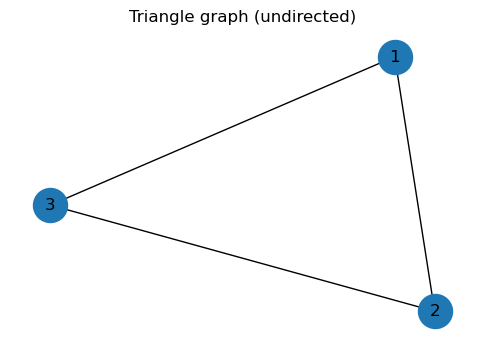

Trace(A^3) = 6
Number of triangles T = Tr(A^3)/6 = 1


In [9]:
# Triangle graph (3-cycle): 1-2-3-1
G_tri = nx.Graph()
G_tri.add_edges_from([(1, 2), (2, 3), (3, 1)])

draw_graph(G_tri, title="Triangle graph (undirected)")

A_tri, nodes_tri = adjacency_matrix_numpy(G_tri)
A3_tri = np.linalg.matrix_power(A_tri, 3)

T_from_trace = np.trace(A3_tri) / 6
print("Trace(A^3) =", int(np.trace(A3_tri)))
print("Number of triangles T = Tr(A^3)/6 =", int(T_from_trace))

## Katz similarity

The slides define the **Katz similarity** between nodes $i$ and $j$ as
$$
\mathrm{Katz}(i,j)
=
\sum_{\ell=0}^{\infty} \alpha^\ell [A^\ell]_{i,j},
$$
where $\alpha>0$ is a parameter that **penalizes long walks**, giving more weight to short connections.

In matrix form, the Katz similarity matrix is
$$
K
=
\sum_{\ell=0}^{\infty} \alpha^\ell A^\ell
=
(\mathbb{I} - \alpha A)^{-1},
\qquad
\text{provided the series converges.}
$$

Below, we compute the Katz similarity for the chain graph.


Katz matrix K = (I - alpha A)^{-1} with alpha = 0.2
[[1.044 0.218 0.045 0.009]
 [0.218 1.089 0.227 0.045]
 [0.045 0.227 1.089 0.218]
 [0.009 0.045 0.218 1.044]]


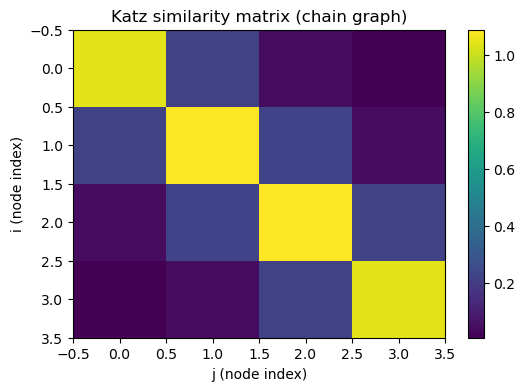

In [10]:
# Katz similarity on the chain graph
A_chain, nodes_chain = adjacency_matrix_numpy(G_chain)
n = A_chain.shape[0]

alpha = 0.2  # choose small alpha for stability
I = np.eye(n)
K = np.linalg.inv(I - alpha * A_chain)

print("Katz matrix K = (I - alpha A)^{-1} with alpha =", alpha)
print(np.round(K, 3))

plt.figure()
plt.imshow(K, aspect="auto")
plt.colorbar()
plt.title("Katz similarity matrix (chain graph)")
plt.xlabel("j (node index)")
plt.ylabel("i (node index)")
plt.show()

# Part II — Paths and connectivity (Slide set 4.B)

## Paths vs.\ walks (recap)

A **path** is a walk with **no repeated nodes**.
A **shortest path** from node $i$ to node $j$ is a path that minimizes the length (number of edges).

The **distance** between nodes $i$ and $j$ is defined as the length of a shortest path:
$$
\mathrm{dist}(i,j).
$$

---

### Undirected graphs

- A graph is **connected** if every pair of nodes is joined by a path.
- A **connected component (CC)** is a maximal connected subgraph.

---

### Directed graphs

- A directed graph is **strongly connected** if every node can reach every other node via directed paths.
- A **strongly connected component (SCC)** is a maximal strongly connected subgraph.


## Example 2: Shortest paths in an undirected graph

We now illustrate the notion of **shortest paths** and **distance** with a concrete undirected graph.

In this example, we will:
- select two nodes $i$ and $j$,
- compute the distance $\mathrm{dist}(i,j)$, i.e., the length of a shortest path,
- and list **all** shortest paths between them.

This example highlights an important point from the slides:
- there may be **multiple distinct shortest paths** between the same pair of nodes,
- even though the distance $\mathrm{dist}(i,j)$ is unique.

The code below uses NetworkX to compute shortest paths and distances directly from the graph structure.


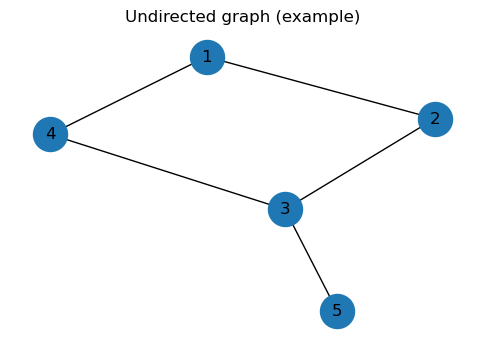

dist(1,5) = 3
All shortest paths: [[1, 2, 3, 5], [1, 4, 3, 5]]


In [12]:
# A small undirected graph with multiple shortest paths between two nodes
G_u = nx.Graph()
G_u.add_edges_from([
    (1, 2), (2, 3), (1, 4), (4, 3),  # two length-2 routes from 1 to 3
    (3, 5)
])

draw_graph(G_u, title="Undirected graph (example)")

source, target = 1, 5
dist = nx.shortest_path_length(G_u, source=source, target=target)
paths = list(nx.all_shortest_paths(G_u, source=source, target=target))

print(f"dist({source},{target}) =", dist)
print("All shortest paths:", paths)

## Connected components (undirected)

In the example below, we use NetworkX to:
- identify all connected components of an undirected graph,
- list the nodes belonging to each component,
- and count how many connected components the graph has.

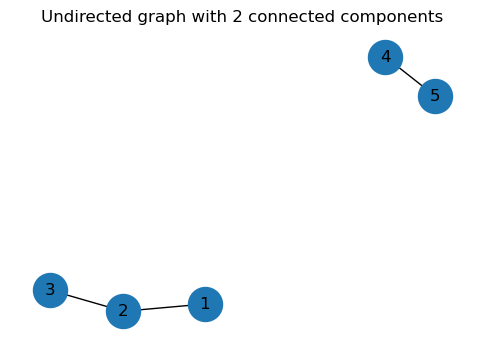

Connected components: [{1, 2, 3}, {4, 5}]
Number of connected components: 2


In [13]:
G_u2 = nx.Graph()
G_u2.add_edges_from([(1, 2), (2, 3), (4, 5)])  # two components: {1,2,3} and {4,5}

draw_graph(G_u2, title="Undirected graph with 2 connected components")

components = list(nx.connected_components(G_u2))
print("Connected components:", components)
print("Number of connected components:", len(components))

## Example 3: Strongly connected components (directed)

In this example, we construct a directed graph that contains:
- one SCC formed by a directed cycle,
- another SCC formed by a smaller cycle,
- and nodes that are not strongly connected to any other node.

Using NetworkX, we will:
- compute all strongly connected components,
- list the nodes in each SCC,
- and illustrate how directed connectivity differs fundamentally from the undirected case.


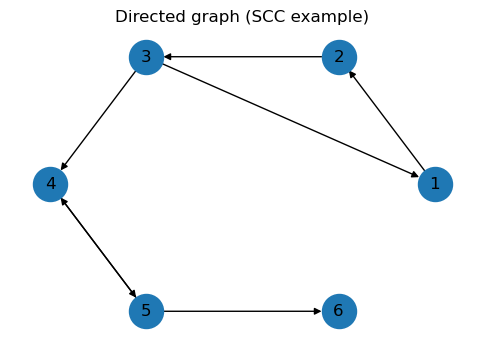

Strongly connected components (as sets):
  {6}
  {4, 5}
  {1, 2, 3}


In [16]:
G_d = nx.DiGraph()
G_d.add_edges_from([
    (1, 2), (2, 3), (3, 1),  # SCC {1,2,3}
    (4, 5), (5, 4),          # SCC {4,5}
    (3, 4),                  # edge from SCC{1,2,3} to SCC{4,5}
    (5, 6)                   # node 6 is its own SCC
])

# Use a circular layout
pos = nx.circular_layout(G_d)

draw_graph(
    G_d,
    title="Directed graph (SCC example)",
    pos=pos,
    directed=True
)

sccs = list(nx.strongly_connected_components(G_d))
print("Strongly connected components (as sets):")
for s in sccs:
    print(" ", s)


## Condensation DAG

The **condensation** of a directed graph is obtained by **contracting each strongly connected component (SCC) into a single meta-node**.

- Each meta-node represents one SCC.
- There is a directed edge between two meta-nodes if there exists at least one directed edge
  between the corresponding SCCs in the original graph.
- The resulting graph is always a **directed acyclic graph (DAG)**.

This construction provides a **high-level summary of the global structure** of a directed graph:
it shows how strongly connected regions are connected to each other, while ignoring internal cycles.

In NetworkX, the condensation graph can be computed directly as:

```python
C = nx.condensation(G)


Condensation edges: [(1, 0), (2, 1)]

SCC membership dictionary (SCC id -> original nodes):
  0: [6]
  1: [4, 5]
  2: [1, 2, 3]


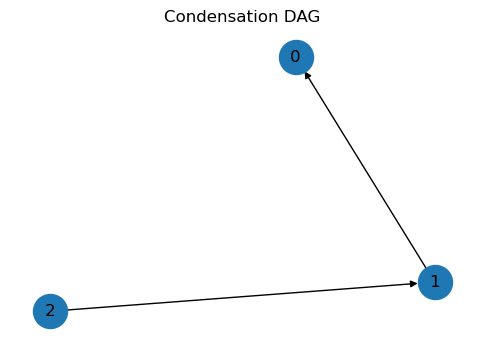

In [18]:
C = nx.condensation(G_d)  # condensation DAG
print("Condensation edges:", list(C.edges()))

# Robust across NetworkX versions:
# mapping: original node -> SCC id
mapping = C.graph["mapping"]

# Build SCC id -> list of original nodes
members = {}
for v, cid in mapping.items():
    members.setdefault(cid, []).append(v)

print("\nSCC membership dictionary (SCC id -> original nodes):")
for cid in sorted(members):
    print(f"  {cid}: {sorted(members[cid])}")

draw_graph(C, title="Condensation DAG", directed=True)


# Summary and takeaways

In this notebook, we connected the **graph-theoretic** and **matrix** views of networks, and used both to study walks, paths, and connectivity.

## What you should now understand

### 1) Walks and adjacency powers
- A walk of length $\ell$ from node $i$ to node $j$ can repeat nodes and edges.
- The number of walks of length $\ell$ is encoded by powers of the adjacency matrix:
$$
\Omega^{(\ell)}_{i,j} = [A^\ell]_{i,j}.
$$
- Diagonal entries $[A^\ell]_{i,i}$ count closed walks of length $\ell$ at node $i$.

### 2) Triangles from the trace
- In a simple undirected graph, the number of triangles is:
$$
T = \frac{\mathrm{Tr}(A^3)}{6}.
$$

### 3) Katz similarity (optional)
- Katz similarity counts walks of all lengths with exponential decay:
$$
\mathrm{Katz}(i,j)=\sum_{\ell=0}^{\infty}\alpha^\ell [A^\ell]_{i,j},
$$
and in matrix form (when it converges),
$$
K = (\mathbb{I}-\alpha A)^{-1}.
$$

### 4) Paths, shortest paths, and distances
- A path is a walk with no repeated nodes.
- The distance $\mathrm{dist}(i,j)$ is the length of a shortest path from $i$ to $j$.

### 5) Connectivity
- In undirected graphs, connected components (CCs) partition the nodes into maximal connected groups.
- In directed graphs, strongly connected components (SCCs) partition the nodes into maximal sets of nodes that can reach each other (in both directions).

### 6) Condensation DAG
- Contracting each SCC into a single meta-node produces the **condensation graph**, which is always a DAG.
- The condensation graph provides a compact summary of how SCCs connect to each other.

---

## Checklist (self-test)

You should be able to:
- compute $A^\ell$ and interpret $[A^\ell]_{i,j}$ as walk counts,
- compute triangles using $\mathrm{Tr}(A^3)/6$,
- compute shortest-path distances and list shortest paths,
- compute CCs (undirected) and SCCs (directed),
- build and interpret the condensation DAG.

If any of these items are unclear, review the corresponding slides (4.A and 4.B) and rerun the relevant notebook section.
